# Import Packages

In [364]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from string import ascii_uppercase
from operator import itemgetter

# useful for ensuring long cryprto addresses can be fully seen
pd.set_option('display.max_colwidth', None)

# useful for making visible plots
plt.rcParams['figure.figsize'] = [10, 10]

# Import Data

### BAYC Metadata
- Information regarding a specific NFT where asset_id is the unique identifier within this NFT token.
    - Note: On the blockchain, the unique identifier is the coposite key of the `asset_id` (i.e. "token id") and the contract address (i.e. the string representing the contract hash of thje respective NFT).
- `NaN`s are expected and inform that the respective NFT does not have the attribute in the represented column.
- Rarity scores are the proportion of `asset_id`s with a respective attribute.
    - Example:
        - ~33% of tokens within BAYC have a "Sea Captain's Hat."
        - ~4% of tokens have no hat as represented by `NaN`.
    - Considerations:
        - The importance of rarity scores is very dependent on the NFT project and overall sentiment of rarity within th NFT market as a whole.
        - Values such as perceived beauty, being "the first," and cultural significance (both on a micro and macro level) can supersede rarity.

In [203]:
metadata = "metadata_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_metadata = pd.read_csv(f"../bayc_nft_data/{metadata}")
print(bayc_metadata.info())
bayc_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   asset_id                      10000 non-null  int64  
 1   attribute_count               10000 non-null  int64  
 2   attribute_count_rarity_score  10000 non-null  float64
 3   Hat_attribute                 7744 non-null   object 
 4   Hat_rarity_score              10000 non-null  float64
 5   Background_attribute          10000 non-null  object 
 6   Background_rarity_score       10000 non-null  float64
 7   Clothes_attribute             8114 non-null   object 
 8   Clothes_rarity_score          10000 non-null  float64
 9   Mouth_attribute               10000 non-null  object 
 10  Mouth_rarity_score            10000 non-null  float64
 11  Fur_attribute                 10000 non-null  object 
 12  Fur_rarity_score              10000 non-null  float64
 13  Ey

,asset_id,attribute_count,attribute_count_rarity_score,Hat_attribute,Hat_rarity_score,Background_attribute,Background_rarity_score,Clothes_attribute,Clothes_rarity_score,Mouth_attribute,Mouth_rarity_score,Fur_attribute,Fur_rarity_score,Eyes_attribute,Eyes_rarity_score,Earring_attribute,Earring_rarity_score,overall_rarity_score
0,0,6,1.878640,NaN,4.432624,Orange,7.855460,Striped Tee,24.271845,Discomfort,48.076923,Robot,37.735849,X Eyes,41.152263,Silver Hoop,11.337868,176.741472
1,1,5,3.937008,NaN,4.432624,Orange,7.855460,Vietnam Jacket,44.642857,Grin,14.025245,Robot,37.735849,Blue Beams,204.081633,NaN,1.423893,318.134569
2,2,5,3.937008,Sea Captain's Hat,32.894737,Aquamarine,7.898894,NaN,5.302227,Bored Cigarette,14.084507,Robot,37.735849,3d,20.533881,NaN,1.423893,123.810996
3,3,5,3.937008,NaN,4.432624,Purple,7.745933,Bone Necklace,49.261084,Tongue Out,49.504950,Cheetah,24.630542,Bored,5.834306,NaN,1.423893,146.770340
4,4,6,1.878640,Party Hat 2,93.457944,Blue,8.051530,Navy Striped Tee,29.940120,Phoneme L,41.493776,Golden Brown,12.853470,Closed,14.084507,NaN,1.423893,203.183880


### BAYC Sales
- One of the most powerful attributes of the blockchain is the ability to validate transaction for yourself via the `transaction_hash`
    - Go to etherscan.com and search the `transaction_hash` represented by `bayc_sales['transaction_hash'][0]` where you can find all information related to the transaction and the NFT.
    - Validate that the information represented in the dataframe matches etherscan.
        - Note: The `seller` address on etherscan is represented by an "ENS Domain" (i.e. the ".eth" names), but hovering over that value will show the expected address.
- `transaction_hash` will serve as the unique identifier and `seller` and `buyer` will be utilized to generate our network graph.

In [204]:
sales = "sales_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_sales = pd.read_csv(f"../bayc_nft_data/{sales}")
print(bayc_sales.info())
bayc_sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_hash  26310 non-null  object 
 1   block_number      26310 non-null  int64  
 2   date              26310 non-null  object 
 3   asset_id          26310 non-null  int64  
 4   seller            26310 non-null  object 
 5   buyer             26310 non-null  object 
 6   maker             26310 non-null  object 
 7   taker             26310 non-null  object 
 8   sale_price_eth    26310 non-null  float64
 9   sale_price_usd    26310 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB
None


,transaction_hash,block_number,date,asset_id,seller,buyer,maker,taker,sale_price_eth,sale_price_usd
0,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,153.200,442685.528567
1,0x1cf83a120540049239c62de9aa6cbc42bae7494cdf029419f2aa0b2df708e13b,14675814,2022-04-28,1397,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,139.750,403820.513167
2,0xf9854d2f02c074f1a2043bc93c5e4e6e4e922e6908a8d1a61ea1ea19e39a729c,14675812,2022-04-28,5226,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0xd30cad3f023888d5a81580fbb80f93102d69e9ef,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0x00000000a50bb64b4bbeceb18715748dface08af,150.000,433438.833453
3,0x38c03f0e17422b62f450262e2931a86efa201d3c22e908457a79a090cd935ab8,14675760,2022-04-28,6498,0x83e7fc69d7c99943afd9122ad0f8bb575e00597c,0x8dd47e819c53138aa18f8651d797e7969f34d1f1,0x83e7fc69d7c99943afd9122ad0f8bb575e00597c,0x8dd47e819c53138aa18f8651d797e7969f34d1f1,145.678,420950.015866
4,0x85ec6a319062f3537420ba60342ff273bbad907bfd9d7559628064455d4b7c26,14675332,2022-04-28,8028,0xe87cc2ea916a7d471976b675d5f72302908e4590,0x98bea99727b297f5eca448d1640075f349c08547,0xe87cc2ea916a7d471976b675d5f72302908e4590,0x98bea99727b297f5eca448d1640075f349c08547,128.000,369867.804547


### BAYC Transfers
- Another way to move an NFT asset to another wallet is via transfers.
- Keep in mind that transfers still require money to move (i.e. "gas fees"), but no money is sent to the receiving wallet.
- For legal transactions, transfers allow the owner to better organize their crypto walllets-- especially moving to wallets with extra security (e.g. cold wallets, and multi-sig authorization)
- For illegal transactions, hacked wallets typically result in the entire wallet contents being transffered to the hacker's respective wallet.

In [205]:
transfers = "transfers_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_transfers = pd.read_csv(f"../bayc_nft_data/{transfers}")
print(bayc_transfers.info())
bayc_transfers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67859 entries, 0 to 67858
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_hash  67859 non-null  object
 1   block_number      67859 non-null  int64 
 2   date              67859 non-null  object
 3   asset_id          67859 non-null  int64 
 4   from_address      67859 non-null  object
 5   to_address        67859 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.1+ MB
None


,transaction_hash,block_number,date,asset_id,from_address,to_address
0,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0xff389e55ee4dd64d82b2b6fefef3f7aa63b218fd,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88
1,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24
2,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762
3,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c
4,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc


# Prepare Data for Network Graph

In [206]:
# prepare sell data
prepared_bayc_sales = bayc_sales \
    .copy() \
    .loc[:,[
        'transaction_hash',
        'block_number',
        'date',
        'asset_id',
        'seller',
        'buyer',
        'sale_price_eth',
        'sale_price_usd',
        ]
    ] \
    .rename(columns={'seller':'from_address', 'buyer':'to_address'}) \
    .assign(
        transaction_type='sell',
        weight=1.00
    ) \
    .astype({'block_number':'str', 'asset_id':'str'})

prepared_bayc_sales.head(3)


,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,weight
0,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,153.20,442685.528567,sell,1.0
1,0x1cf83a120540049239c62de9aa6cbc42bae7494cdf029419f2aa0b2df708e13b,14675814,2022-04-28,1397,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,139.75,403820.513167,sell,1.0
2,0xf9854d2f02c074f1a2043bc93c5e4e6e4e922e6908a8d1a61ea1ea19e39a729c,14675812,2022-04-28,5226,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0xd30cad3f023888d5a81580fbb80f93102d69e9ef,150.00,433438.833453,sell,1.0


In [207]:
# prepare transfer data
prepared_bayc_transfers = bayc_transfers \
    .copy() \
    .assign(
        sale_price_eth=0.00,
        sale_price_usd=0.00,
        transaction_type='transfer',
        weight=0.01
    ) \
    .astype({'block_number':'str', 'asset_id':'str'})

prepared_bayc_transfers.head(3)

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,weight
0,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0xff389e55ee4dd64d82b2b6fefef3f7aa63b218fd,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0.0,0.0,transfer,0.01
1,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24,0.0,0.0,transfer,0.01
2,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,0.0,0.0,transfer,0.01


#### Determine if there are duplicate hashes for sales and transfers:
- The ethereum blockchain represents sales as both the exchange of ethereum as a "sale" and the exchange of the NFT as a "transfer" resulting in duplicates.
- This results in duplicate `transaction_hash`s for sale transactions where the transfer is also included.
- We need to remove these duplicate `transaction_hash`s for only the transfers.

Results:
- unique_sales_hash_list: 26113
- unique_transfer_hash_list: 54577
- unique_hash_set: 54577

The fact that the length `unique_hash_set` is not greater than `unique_transfer_hash_list` implies that unique sales `transaction_hash`s are within `unique_transfer_hash_list` as well.

In [212]:
unique_sales_hash_list = prepared_bayc_sales['transaction_hash'] \
    .unique() \
    .tolist()
print(len(unique_sales_hash_list))

unique_transfer_hash_list = prepared_bayc_transfers['transaction_hash'] \
    .unique() \
    .tolist()
print(len(unique_transfer_hash_list))

unique_hash_set = set(unique_sales_hash_list + unique_transfer_hash_list)
print(len(unique_hash_set))

26113
54577
54577


In [214]:
# repeating for readability across cells
unique_sales_hash_list = prepared_bayc_sales['transaction_hash'] \
    .unique() \
    .tolist()

# you can use `isin()` with a `~` for "not in" but I find `query()` to be more
# readable
filtered_prepared_bayc_transfers = prepared_bayc_transfers \
    .query('transaction_hash not in @unique_sales_hash_list')

print(len(filtered_prepared_bayc_transfers['transaction_hash']))

41585


In [336]:
# union data
prepared_bayc_sales_transfers = pd.concat(
    [prepared_bayc_sales, filtered_prepared_bayc_transfers]
    ) \
    .reset_index(drop=True)

prepared_bayc_sales_transfers.describe(include =['object', 'float', 'int'])

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,weight
count,67895,67895,67895,67895,67895,67895,67895.000000,6.789500e+04,67895,67895.000000
unique,54577,49989,372,10000,15320,19613,NaN,NaN,2,NaN
top,0x2d654336d0ce4ab3601951bf9e1d7b8474537b6273338d5f326af4d44bb25a70,12346915,2021-05-01,5520,0x0000000000000000000000000000000000000000,0xc310e760778ecbca4c65b6c559874757a4c4ece0,NaN,NaN,transfer,NaN
freq,51,85,11374,48,10000,1383,NaN,NaN,41585,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,8.589896,2.732988e+04,NaN,0.393635
std,NaN,NaN,NaN,NaN,NaN,NaN,26.955004,8.581617e+04,NaN,0.482313
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,0.010000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,0.010000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,0.010000
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.550000,4.178787e+03,NaN,1.000000


# Create Network Graph Data
- Documentation: https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html
- Further Reference: https://stackoverflow.com/questions/53834084/convert-pandas-dataframe-to-directed-networkx-multigraph

In [216]:
# Directed Multi-graph
DMG = nx.from_pandas_edgelist(
    df=prepared_bayc_sales_transfers,
    source='from_address',
    target='to_address',
    edge_attr=True,
    create_using=nx.MultiDiGraph()
)

# confirm it's correct graph
print(f'Is graph directed: {DMG.is_directed()}')
print(f'Is multigraph: {DMG.is_multigraph()}')

# view the first two nodes with edge data
list(DMG.edges(data=True))[0:2]

Is graph directed: True
Is multigraph: True


[('0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3',
  '0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc',
  {'transaction_hash': '0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4',
   'block_number': '14675897',
   'date': '2022-04-28',
   'asset_id': '7438',
   'sale_price_eth': 153.2,
   'sale_price_usd': 442685.5285671361,
   'transaction_type': 'sell',
   'weight': 1.0}),
 ('0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3',
  '0xd8fdd6031fa27194f93e1a877f8bf5bfc9b47e1e',
  {'transaction_hash': '0x7b4797061eb16d73a28a869e51745e471e2849a55c80459b2aff7f0205925d74',
   'block_number': '14654313',
   'date': '2022-04-25',
   'asset_id': '5954',
   'sale_price_eth': 0.0,
   'sale_price_usd': 0.0,
   'transaction_type': 'transfer',
   'weight': 0.01})]

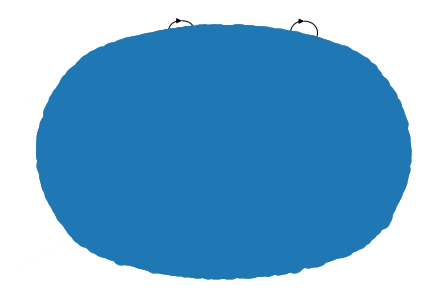

In [7]:
# takes about 25min
# nx.draw(DMG)

{('0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd', '0x8b30bc803dc3a279bdc9a488212e2f4d8d722022', 0): 276462.0, ('0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd', '0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9', 0): 124215.39, ('0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd', '0xcbc9f463f83699d20dd5b54be5262be69a0aea9f', 0): 0.0, ('0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9', '0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd', 0): 165677.05, ('0xbec83c3221a42b27ccab595a6d4513a0086fdf73', '0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd', 0): 95358.55, ('0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c', '0x7d88aa989068e65190031a13c809e27fcb3aca52', 0): 40528.08, ('0x7d88aa989068e65190031a13c809e27fcb3aca52', '0xfa68378c74d13a9509fefd0a09e784e69a3250d8', 0): 0.0, ('0xcbc9f463f83699d20dd5b54be5262be69a0aea9f', '0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd', 0): 0.0, ('0x6324e74b8e167c1b40c2880f4513e1edde8b7153', '0xbec83c3221a42b27ccab595a6d4513a0086fdf73', 0): 0.0, ('0xfa68378c74d13a9509fefd0a09e784e69a3250d8', '0x6324

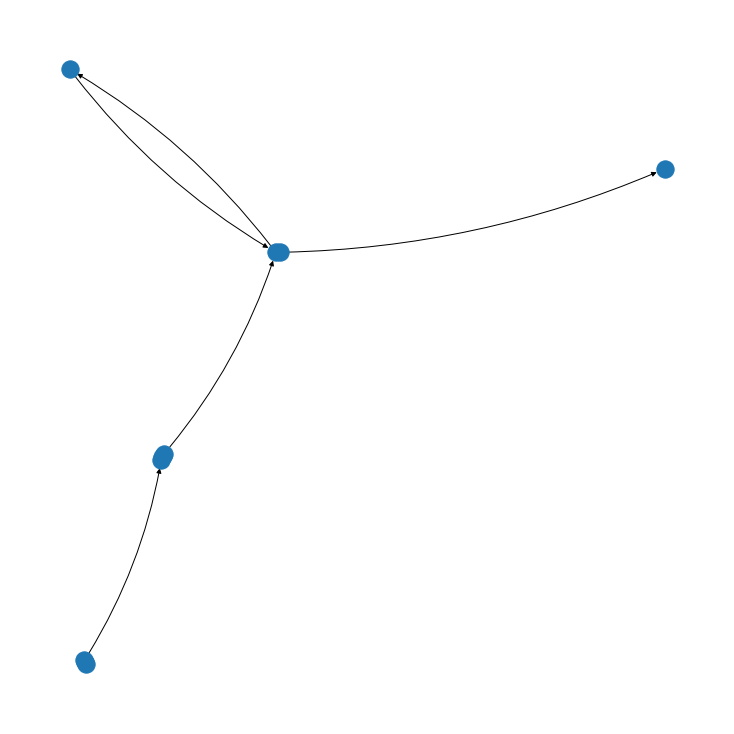

In [220]:
class NftToNetworkGraph:
    def __init__(self, nft_transactions_data: pd.DataFrame) -> None:
        self.nft_data = nft_transactions_data
    
    def filter_to_specific_nft(self, asset_id: str) -> pd.DataFrame:
        df = self.nft_data.copy()
        filtered_nft_data = df \
            .loc[df['asset_id']==asset_id] \
            .reset_index()
        return filtered_nft_data
    
    def generate_network(self, filtered_nft_data: pd.DataFrame) -> nx.classes.multidigraph.MultiDiGraph:
        asset_dmg = nx.from_pandas_edgelist(
            df=filtered_nft_data,
            source='from_address',
            target='to_address',
            edge_attr=True,
            create_using=nx.MultiDiGraph()
            )
        # print statements to highlight underlying data for this example
        print(nx.get_edge_attributes(asset_dmg,'sale_price_usd'))
        print(list(DMG.edges(data=True))[0:2])
        
        return asset_dmg
    
    def generate_graph_from_asset_id(self, asset_id: str) -> None:
        filtered_nft_data = self.filter_to_specific_nft(asset_id)
        asset_dmg = self.generate_network(filtered_nft_data)

        # kamada_kawai_layout provided the clearest orginization of nodes for
        # identifying wash trading and seeing sequential trades.
        pos = nx.kamada_kawai_layout(asset_dmg)
        nx.draw(asset_dmg, pos=pos, connectionstyle='arc3, rad = 0.1')
        plt.show()

nft_to_graph = NftToNetworkGraph(prepared_bayc_sales_transfers)
nft_to_graph.generate_graph_from_asset_id('8099')

Now that we have a graph to start off with, we now need to add more detail for our audience to unsderstand what they are looking at within this graph. Emphasis on telling a story of the transictions of a particular NFT.
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

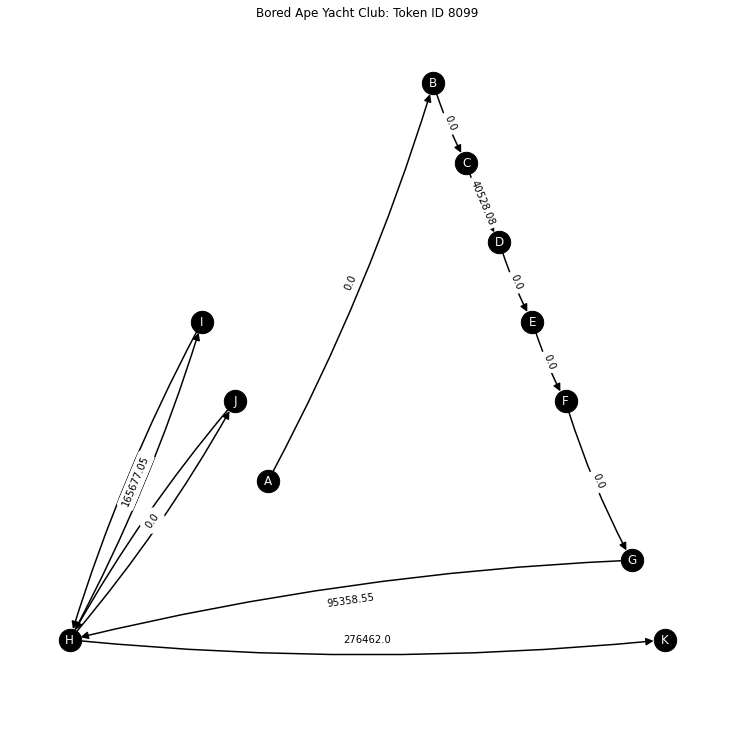

In [366]:
class NftToNetworkGraph:
    def __init__(self, nft_transactions_data: pd.DataFrame) -> None:
        self.nft_transactions_data = nft_transactions_data
    
    # def _calculate_profit(self, filtered_nft_data: pd.DataFrame) -> pd.DataFrame:
    #     df = filtered_nft_data.copy()
    #     profit_data = df \
    #         . 

    def _filter_to_specific_nft(self, nft_data: pd.DataFrame, asset_id: str) -> pd.DataFrame:
        df = nft_data.copy()
        
        filtered_nft_data = df.loc[df['asset_id']==asset_id]

        return filtered_nft_data
    
    # this function is a great candidate for refactoring later
    def _get_ordered_node_labels(self, nft_data: pd.DataFrame) -> pd.DataFrame:
        df = nft_data.copy()

        unique_ordered_from_addresses = df \
            .loc[:,['from_address', 'date']] \
            .rename(columns={'from_address':'address'})
        
        unique_ordered_to_addresses = df \
            .loc[:,['to_address', 'date']] \
            .rename(columns={'to_address':'address'})
        
        unique_ordered_all_addresses = pd.concat(
            [unique_ordered_from_addresses, unique_ordered_to_addresses]
            ) \
            .groupby('address') \
            .agg('min') \
            .sort_values('date', ascending=True) \
            .reset_index()
        
        # https://stackoverflow.com/questions/50860366/pandas-set-row-values-to-letter-of-the-alphabet-corresponding-to-index-number
        # get upper case letter in order of index
        node_label_series = pd.Series(
            itemgetter(*unique_ordered_all_addresses.index)(ascii_uppercase),
            name='node_label'
            )
        address_labels_df = pd.concat(
            [unique_ordered_all_addresses, node_label_series], axis=1
            ) \
            .loc[:,['address', 'node_label']]

        from_node_label_df = df \
            .merge(address_labels_df, how='left', left_on='from_address', right_on='address') \
            .rename(columns={'node_label':'from_node_label'})
        
        to_from_node_label_df = from_node_label_df \
            .merge(address_labels_df, how='left', left_on='to_address', right_on='address') \
            .rename(columns={'node_label':'to_node_label'})
        
        # drop duplicate merge columns
        to_from_node_label_df.drop(columns=['address_x', 'address_y'], axis=1, inplace=True)

        return to_from_node_label_df

    def prepare_nft_data(self, asset_id: str) -> pd.DataFrame:
        nft_df = self.nft_transactions_data.copy()
        filtered_df = self._filter_to_specific_nft(nft_df, asset_id)
        label_df = self._get_ordered_node_labels(filtered_df)

        return label_df

    
    def generate_network(self, prepared_nft_data: pd.DataFrame) -> nx.classes.digraph.DiGraph:
        asset_dmg = nx.from_pandas_edgelist(
            df=prepared_nft_data,
            source='from_node_label',
            target='to_node_label',
            edge_attr=True,
            create_using=nx.DiGraph()
            )
        return asset_dmg
    
    def generate_graph_from_asset_id(self, asset_id: str) -> None:
        prepared_nft_data = self.prepare_nft_data(asset_id)
        asset_dmg = self.generate_network(prepared_nft_data)

        # planar_layout positionsq nodes without edge intersections
        pos = nx.planar_layout(asset_dmg)
        nx.draw(
            G=asset_dmg,
            pos=pos,
            arrowsize=15,
            connectionstyle='arc3, rad = 0.05',
            node_color='black',
            with_labels=True,
            node_size=500,
            # cmap
            width=1.5
            )
        nx.draw_networkx_labels(G=asset_dmg, pos=pos, font_color='whitesmoke')
        nx.draw_networkx_edge_labels(
            asset_dmg,
            pos=pos,
            edge_labels=nx.get_edge_attributes(asset_dmg,'sale_price_usd'))
        plt.title(f'Bored Ape Yacht Club: Token ID {asset_id}')
        plt.show()

nft_to_graph = NftToNetworkGraph(prepared_bayc_sales_transfers)
nft_to_graph.generate_graph_from_asset_id('8099')

In [317]:
df_test = nft_to_graph.prepare_nft_data('8099')

df_test

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,weight,node_label
0,0xc67422036d476e2c917a0c00e2ae13697739b315d1c56f7490a7c37741a20b27,13550293,2021-11-04,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0x8b30bc803dc3a279bdc9a488212e2f4d8d722022,60.0,276462.00,sell,1.00,H
1,0xe0ff757a80587929855733ea47553ff3b23de9bed88f3781839aef5823312d35,12989906,2021-08-09,8099,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,55.0,165677.05,sell,1.00,I
2,0x66b3aab648ef82a6eea7e35568a8733bdfb425e638d52c862d4d2fd54a599690,12975935,2021-08-07,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,43.0,124215.39,sell,1.00,H
3,0x8849abd87c7c7f3feab31c95cccc857b7f80483f29185c153af73f724faf92ac,12962897,2021-08-05,8099,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,35.0,95358.55,sell,1.00,G
4,0x0332e15964794aee4345d92085106fea0fe9d1435710356aeece3fcf78a4d195,12675895,2021-06-21,8099,0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c,0x7d88aa989068e65190031a13c809e27fcb3aca52,18.0,40528.08,sell,1.00,C
5,0x4ee34a5330853a354aad0a809e43bd19964c53a8fe6ffd98dcb0e3e0c1d4b91b,13136679,2021-09-01,8099,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0.0,0.00,transfer,0.01,J
6,0x1846ebae1ae3d234ca70c809eacf8b460ffefcbebe1f77b9563a38726f69f9a9,13117777,2021-08-29,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,0.0,0.00,transfer,0.01,H
7,0x0f2594abc12cc22b20ef619bc85e055c0edf07dfdd2a1287addad656b44f6be8,12906302,2021-07-27,8099,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,0.0,0.00,transfer,0.01,F
8,0xa8f66e66317bb0fd14ec475663332d3646b9c0699a974f774d8fe8f9f8520311,12894143,2021-07-25,8099,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,0.0,0.00,transfer,0.01,E
9,0xfa067fd500843592e33fda0279e2c9031321b0fccae5c360cfe6459242260b38,12874792,2021-07-22,8099,0x7d88aa989068e65190031a13c809e27fcb3aca52,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,0.0,0.00,transfer,0.01,D


In [305]:
df_test

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,weight
0,0xc67422036d476e2c917a0c00e2ae13697739b315d1c56f7490a7c37741a20b27,13550293,2021-11-04,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0x8b30bc803dc3a279bdc9a488212e2f4d8d722022,60.0,276462.00,sell,1.00
1,0x4ee34a5330853a354aad0a809e43bd19964c53a8fe6ffd98dcb0e3e0c1d4b91b,13136679,2021-09-01,8099,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0.0,0.00,transfer,0.01
2,0x1846ebae1ae3d234ca70c809eacf8b460ffefcbebe1f77b9563a38726f69f9a9,13117777,2021-08-29,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0xcbc9f463f83699d20dd5b54be5262be69a0aea9f,0.0,0.00,transfer,0.01
3,0xe0ff757a80587929855733ea47553ff3b23de9bed88f3781839aef5823312d35,12989906,2021-08-09,8099,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,55.0,165677.05,sell,1.00
4,0x66b3aab648ef82a6eea7e35568a8733bdfb425e638d52c862d4d2fd54a599690,12975935,2021-08-07,8099,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,0x7e99611cf208cb097497a59b3fb7cb4dfd115ea9,43.0,124215.39,sell,1.00
5,0x8849abd87c7c7f3feab31c95cccc857b7f80483f29185c153af73f724faf92ac,12962897,2021-08-05,8099,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,0xe4bc96b24e0bdf87b4b92ed39c1aef8839b090dd,35.0,95358.55,sell,1.00
6,0x0f2594abc12cc22b20ef619bc85e055c0edf07dfdd2a1287addad656b44f6be8,12906302,2021-07-27,8099,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,0xbec83c3221a42b27ccab595a6d4513a0086fdf73,0.0,0.00,transfer,0.01
7,0xa8f66e66317bb0fd14ec475663332d3646b9c0699a974f774d8fe8f9f8520311,12894143,2021-07-25,8099,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,0x6324e74b8e167c1b40c2880f4513e1edde8b7153,0.0,0.00,transfer,0.01
8,0xfa067fd500843592e33fda0279e2c9031321b0fccae5c360cfe6459242260b38,12874792,2021-07-22,8099,0x7d88aa989068e65190031a13c809e27fcb3aca52,0xfa68378c74d13a9509fefd0a09e784e69a3250d8,0.0,0.00,transfer,0.01
9,0x0332e15964794aee4345d92085106fea0fe9d1435710356aeece3fcf78a4d195,12675895,2021-06-21,8099,0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c,0x7d88aa989068e65190031a13c809e27fcb3aca52,18.0,40528.08,sell,1.00
